# Results of first case study

In [14]:
import sys

sys.path.append(
    "C:/Users/Anwender/Documents/GitHub/RiVaPy_development/TimeSeriesTransformer/"
    #"/home/doeltz/doeltz/development/TimeSeriesTransformer/"
)
import numpy as np
import pandas as pd
from pytorch_forecasting import TimeSeriesDataSet
from pytorch_forecasting import GroupNormalizer
from pytorch_forecasting import TemporalFusionTransformer, QuantileLoss
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import LearningRateMonitor
import sandbox.params
import torch
import matplotlib.pyplot as plt
from src.model_data_processing import *

## Load data and model

In [ ]:
data = pd.read_csv(
    "../data/DAprices_201810010000_202505140000_hourly.csv",
    index_col=0,
    sep=";",
    decimal=",",
    # converters={"GWL": convert_decimal},  # Replace with your column name
)
data["Prognostizierte Erzeugung PV und Wind"] = data[
    "Prognostizierte Erzeugung PV und Wind"
].str.replace(",", ".")
data["Erzeugung Erneuerbare"] = data["Erzeugung Erneuerbare"].str.replace(",", ".")
data["Erzeugung Konventionelle"] = data["Erzeugung Konventionelle"].str.replace(
    ",", "."
)
data["Residuallast"] = data["Residuallast"].str.replace(",", ".")
time_df = preprocess_input_data(data)
training_cutoff = time_df[sandbox.params.time_idx].max() - sandbox.params.max_prediction_length

In [3]:
training = TimeSeriesDataSet(
    time_df[lambda x: x.hours_from_start <= training_cutoff],
    time_idx=sandbox.params.time_idx,
    target=sandbox.params.target,
    group_ids=sandbox.params.group_ids,
    min_encoder_length=sandbox.params.max_encoder_length // 2,
    max_encoder_length=sandbox.params.max_encoder_length,
    min_prediction_length=sandbox.params.min_prediction_length,
    max_prediction_length=sandbox.params.max_prediction_length,
    static_categoricals=sandbox.params.static_categoricals,
    time_varying_known_reals=sandbox.params.time_varying_known_reals,
    time_varying_unknown_reals=sandbox.params.time_varying_unknown_reals,
    # target_normalizer=GroupNormalizer(groups=["zone"], transformation="softplus"),
    add_relative_time_idx=sandbox.params.add_relative_time_idx,
    add_target_scales=sandbox.params.add_target_scales,
    add_encoder_length=sandbox.params.add_encoder_length,
    # allow_missing_timesteps=True,
)
validation = TimeSeriesDataSet.from_dataset(
    training, time_df, predict=True, stop_randomization=True
)

# if you have a strong GPU, feel free to increase the number of workers
train_dataloader = training.to_dataloader(
    train=True, batch_size=sandbox.params.batch_size, num_workers=0
)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=sandbox.params.batch_size * 10, num_workers=0
)


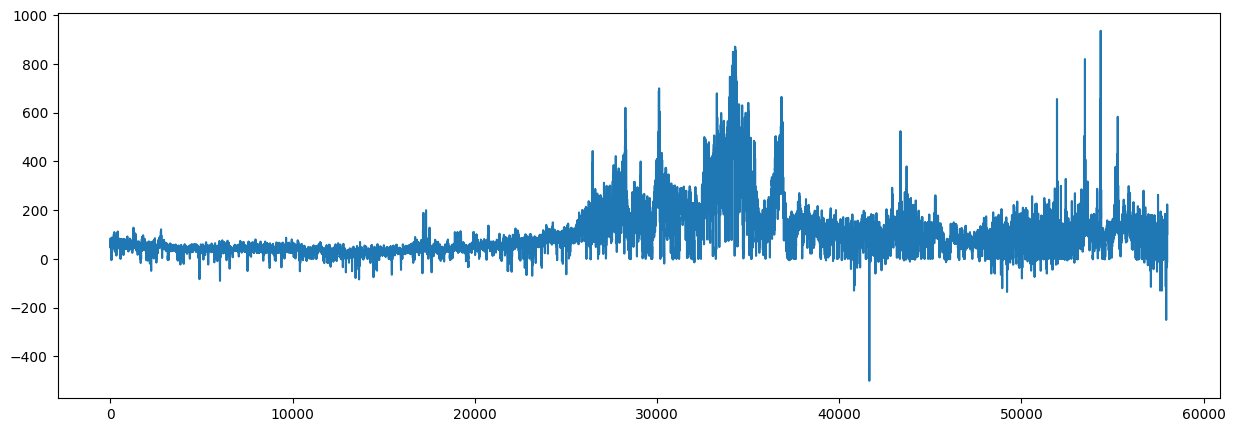

In [4]:
plt.figure(figsize=[15,5])
plt.plot(time_df['DAprices'])

In [5]:
# Example (you must use your actual model parameters!)
best_tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=sandbox.params.learning_rate,
    hidden_size=sandbox.params.hidden_size,
    attention_head_size=sandbox.params.attention_head_size,
    dropout=sandbox.params.dropout,
    hidden_continuous_size=sandbox.params.hidden_continuous_size,
    output_size=sandbox.params.output_size,  # there are 7 quantiles by default: [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]
    loss=QuantileLoss(),
    log_interval=sandbox.params.log_interval,
    reduce_on_plateau_patience=sandbox.params.reduce_on_plateau_patience,
)

# Load state dict
best_tft.load_state_dict(torch.load("C:/Users/Anwender/Documents/GitHub/RiVaPy_development/TimeSeriesTransformer/sandbox/best_tft_cpu.pt", map_location="cpu"))

c:\Users\Anwender\.conda\envs\TST_env\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\Anwender\.conda\envs\TST_env\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


<All keys matched successfully>

In [7]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)]).to('cpu')
predictions = best_tft.predict(val_dataloader)

#average p50 loss overall
print((actuals - predictions).abs().mean().item())
#average p50 loss per time series
print((actuals - predictions).abs().mean(axis=1))

c:\Users\Anwender\.conda\envs\TST_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Anwender\.conda\envs\TST_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


12.477187156677246
tensor([12.4772])


c:\Users\Anwender\.conda\envs\TST_env\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\Anwender\.conda\envs\TST_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Anwender\.conda\envs\TST_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [8]:

#Take a look at what the raw_predictions variable contains

raw_predictions = best_tft.predict(val_dataloader, mode="raw", return_x=True)
print(raw_predictions._fields)
#('output', 'x', 'index', 'decoder_lengths', 'y')

print('\n')
print(raw_predictions.output._fields)
# ('prediction',
# 'encoder_attention',
# 'decoder_attention',
# 'static_variables',
# 'encoder_variables',
# 'decoder_variables',
# 'decoder_lengths',
# 'encoder_lengths')

print('\n')
print(raw_predictions.output.prediction.shape)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


('output', 'x', 'index', 'decoder_lengths', 'y')


('prediction', 'encoder_attention', 'decoder_attention', 'static_variables', 'encoder_variables', 'decoder_variables', 'decoder_lengths', 'encoder_lengths')


torch.Size([1, 24, 7])


c:\Users\Anwender\.conda\envs\TST_env\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\Anwender\.conda\envs\TST_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Anwender\.conda\envs\TST_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [11]:
raw_predictions

Prediction(output=Output(prediction=tensor([[[  67.8802,   79.4000,   84.8735,   89.6178,   95.1283,  100.0078,
           107.6824],
         [  60.6965,   74.0852,   80.4521,   85.7736,   91.4841,   96.2210,
           103.1337],
         [  56.3381,   70.7908,   77.5432,   83.0047,   88.6492,   93.0963,
            99.2363],
         [  56.0964,   70.9094,   77.7522,   83.2408,   88.9522,   93.4544,
            99.6796],
         [  58.9845,   73.5414,   80.2497,   85.7370,   91.7422,   96.7383,
           104.0410],
         [  67.8544,   80.6786,   86.6848,   91.9818,   98.5469,  104.6927,
           114.6150],
         [  95.9432,  107.0338,  112.3391,  117.8182,  125.9409,  134.4608,
           149.2377],
         [ 102.7798,  115.3056,  121.5639,  128.5698,  138.7674,  149.7867,
           168.3447],
         [  65.5040,   84.1998,   93.4764,  101.8921,  111.1428,  119.7539,
           132.1996],
         [  -3.8284,   27.6538,   45.1421,   59.9510,   72.2160,   82.0344,
      

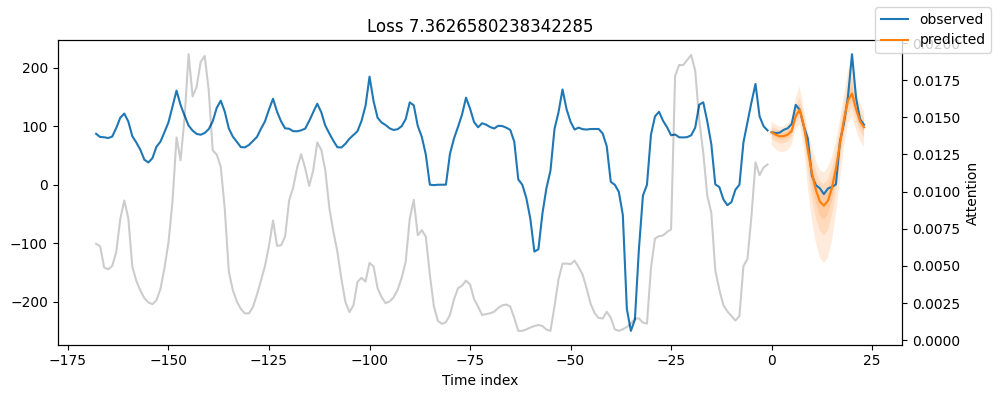

In [9]:
for idx in range(1):  # plot all 5 consumers
    fig, ax = plt.subplots(figsize=(10, 4))
    best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=QuantileLoss(),ax=ax)
    plt.xlabel('time step')
    #plt.ylabel('Day Ahead Price')


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\Anwender\.conda\envs\TST_env\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\Anwender\.conda\envs\TST_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Anwender\.conda\envs\TST_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(

{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x300 with 1 Axes>,
 'encoder_variables': <Figure size 700x400 with 1 Axes>,
 'decoder_variables': <Figure size 700x375 with 1 Axes>}

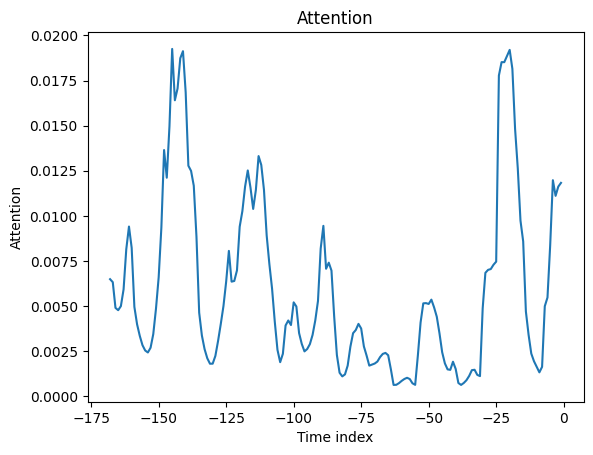

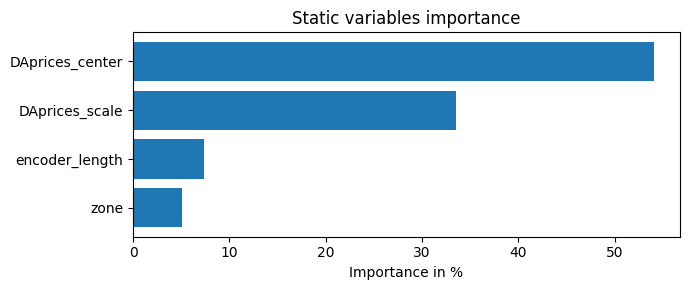

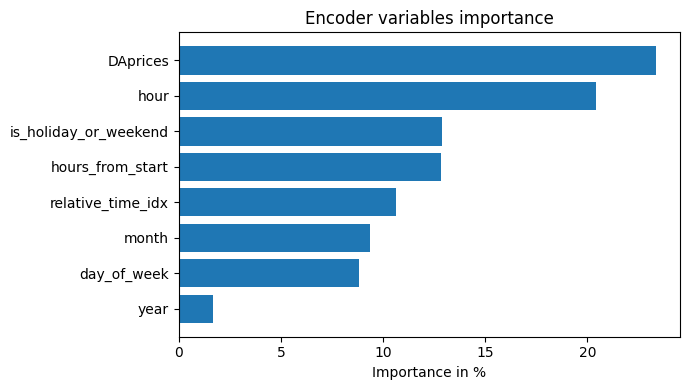

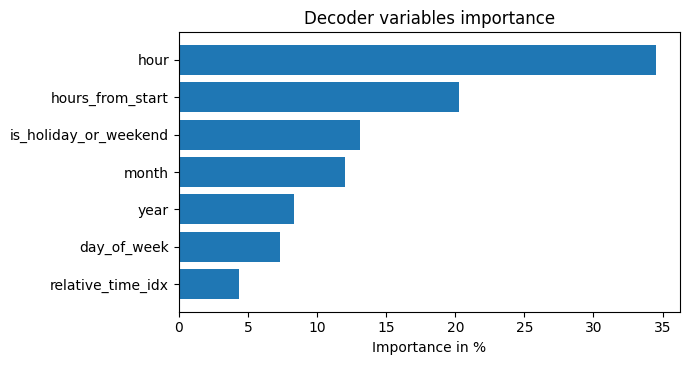

In [10]:
raw_predictions= best_tft.predict(val_dataloader, mode="raw", return_x=True)
interpretation = best_tft.interpret_output(raw_predictions.output, reduction="sum")
best_tft.plot_interpretation(interpretation)